In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import polars as pl
from matplotlib.animation import FuncAnimation

In [15]:
df_data = (
    pl.read_csv('restricted_data.csv')
    .with_columns(import_export_diff=pl.col('import_export_diff') * pl.when(pl.col('import_export_diff_flag')).then(1).otherwise(-1) + np.random.normal(0, .5, size=44640))
    .with_columns(stored_energy_time_diff=pl.col('stored_energy_time_diff') * pl.when(pl.col('import_export_diff_flag')).then(1).otherwise(-1) + np.random.normal(0, .5, size=44640))
    .select(
        'DeviceID',
        ((pl.col('import_export_diff') - pl.min('import_export_diff')) / (pl.max('import_export_diff') - pl.min('import_export_diff'))).alias('import_export_diff'),
        ((pl.col('stored_energy_time_diff') - pl.min('stored_energy_time_diff')) / (pl.max('stored_energy_time_diff') - pl.min('stored_energy_time_diff'))).alias('stored_energy_time_diff'),
        # ((pl.col('import_fulfillment') - pl.min('import_fulfillment')) / (pl.max('import_fulfillment') - pl.min('import_fulfillment'))).alias('import_fulfillment'),
        # ((pl.col('export_fulfillment') - pl.min('export_fulfillment')) / (pl.max('export_fulfillment') - pl.min('export_fulfillment'))).alias('export_fulfillment'),
    )
    .with_columns(test_column=(pl.col('import_export_diff') + pl.col('stored_energy_time_diff')) / 3)
    .with_columns(test_column_2=(pl.col('import_export_diff') + pl.col('stored_energy_time_diff'))  / 2)
)

df_data.head()

DeviceID,import_export_diff,stored_energy_time_diff,test_column,test_column_2
str,f64,f64,f64,f64
"""OM1""",0.498303,0.480292,0.326198,0.489298
"""OM1""",0.653006,0.60911,0.420705,0.631058
"""OM1""",0.403222,0.451911,0.285044,0.427567
"""OM1""",0.497901,0.703627,0.400509,0.600764
"""OM1""",0.368407,0.448013,0.27214,0.40821


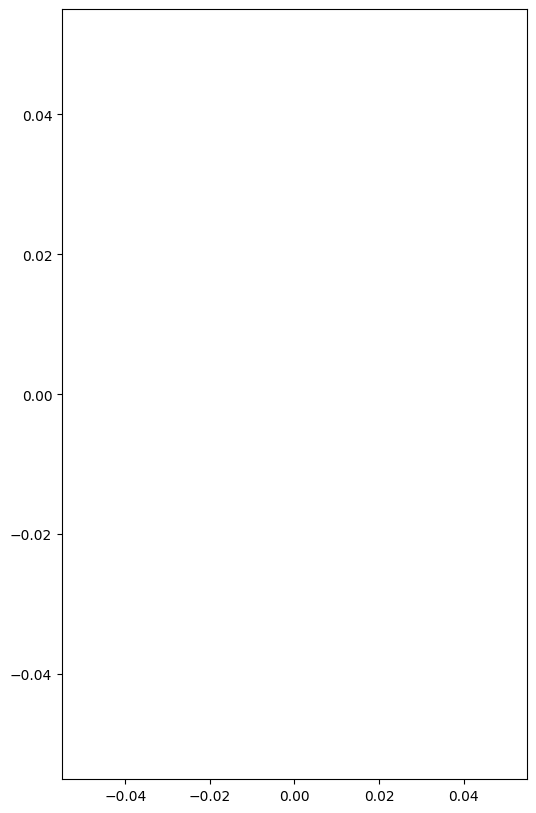

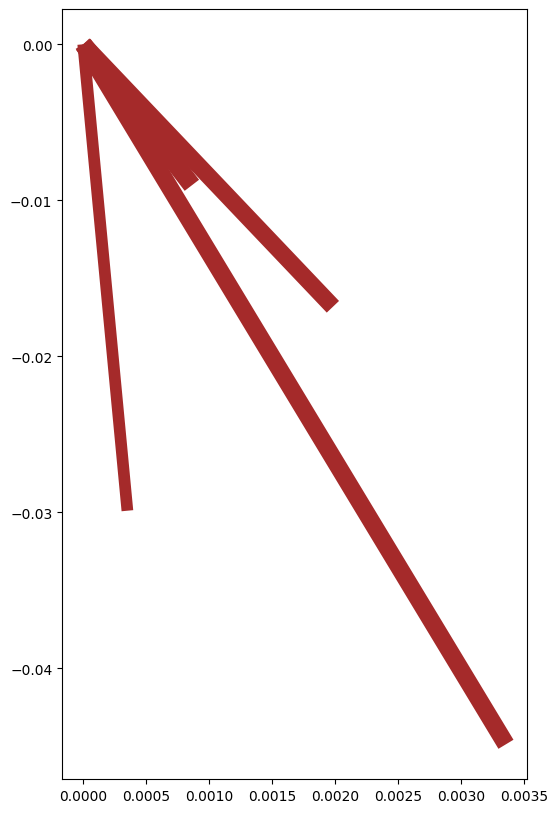

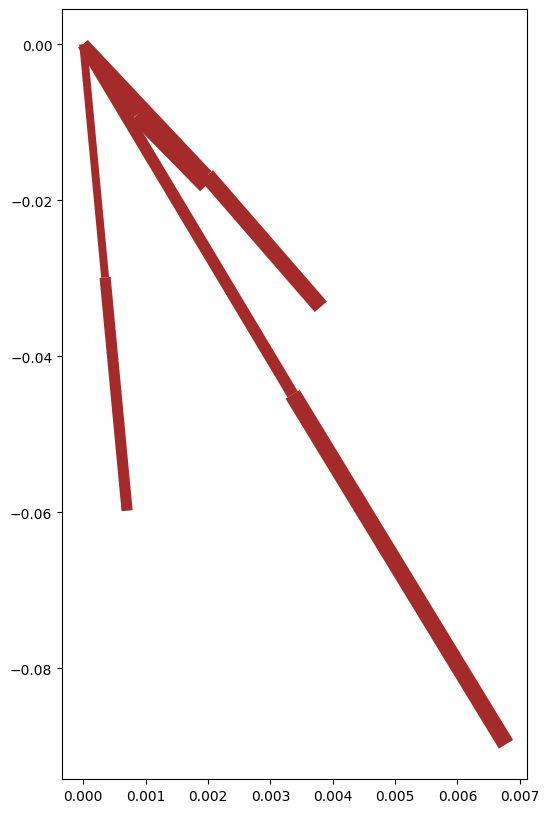

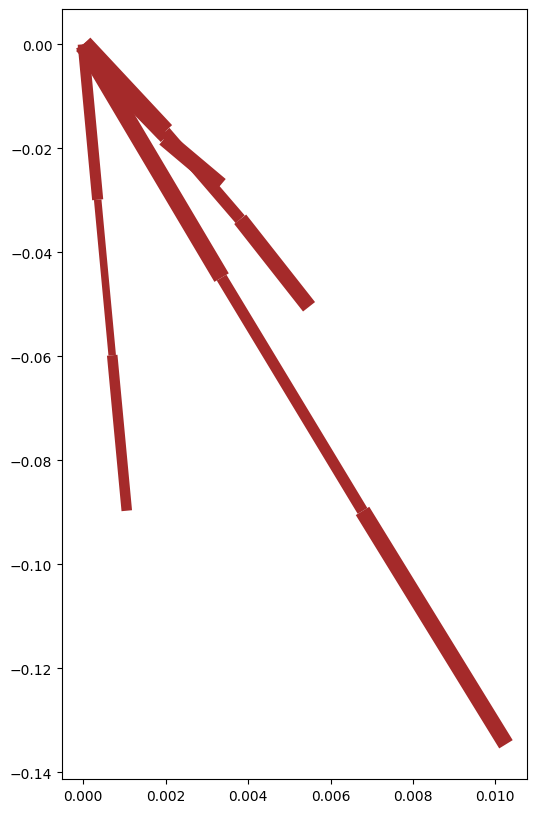

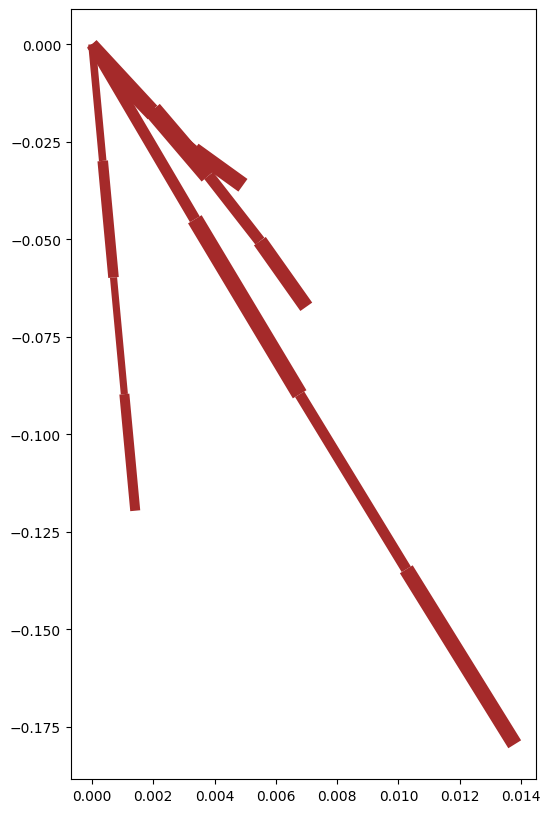

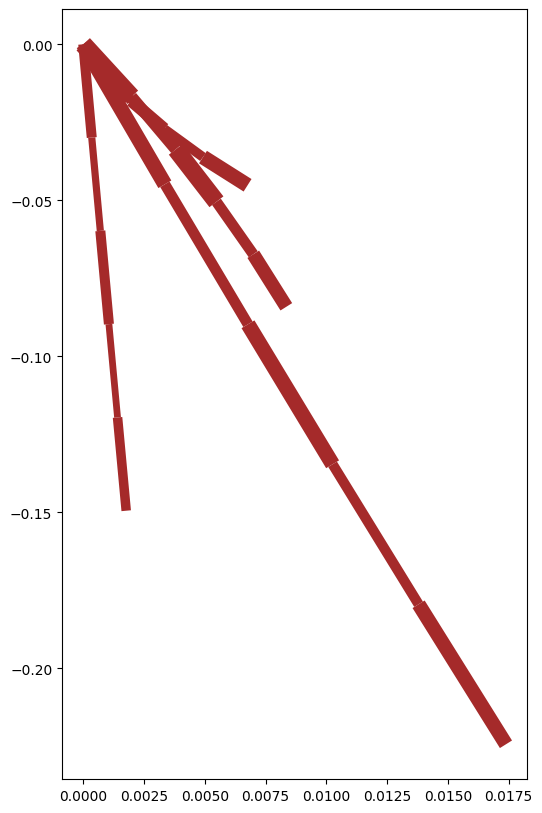

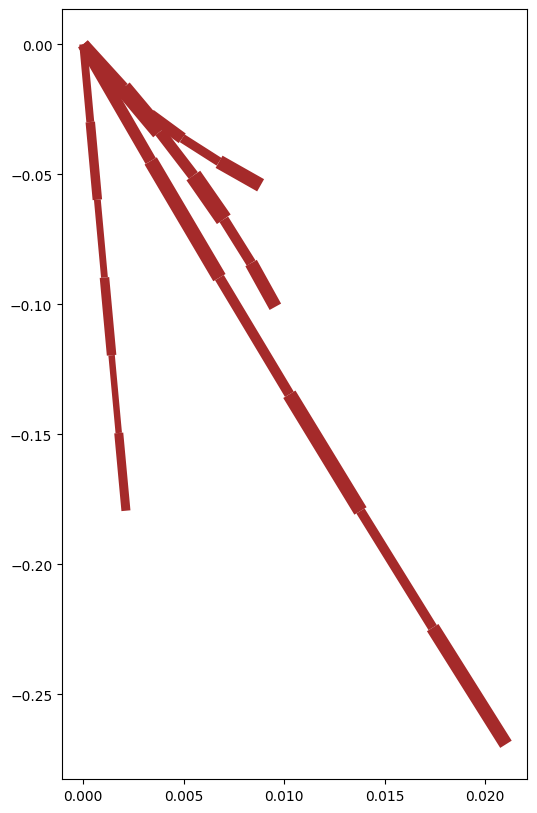

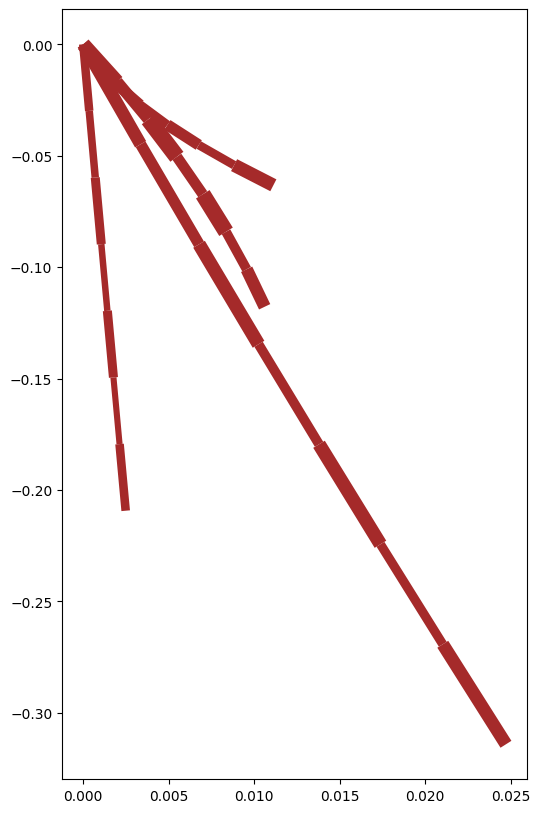

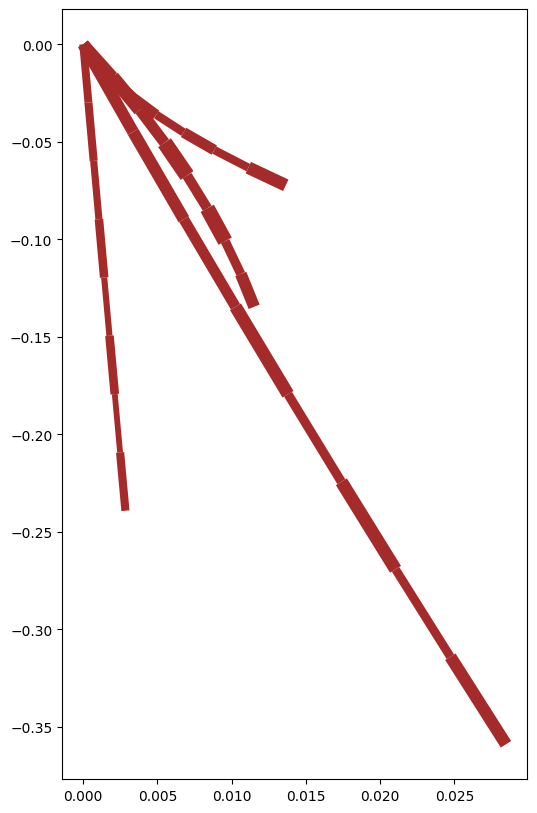

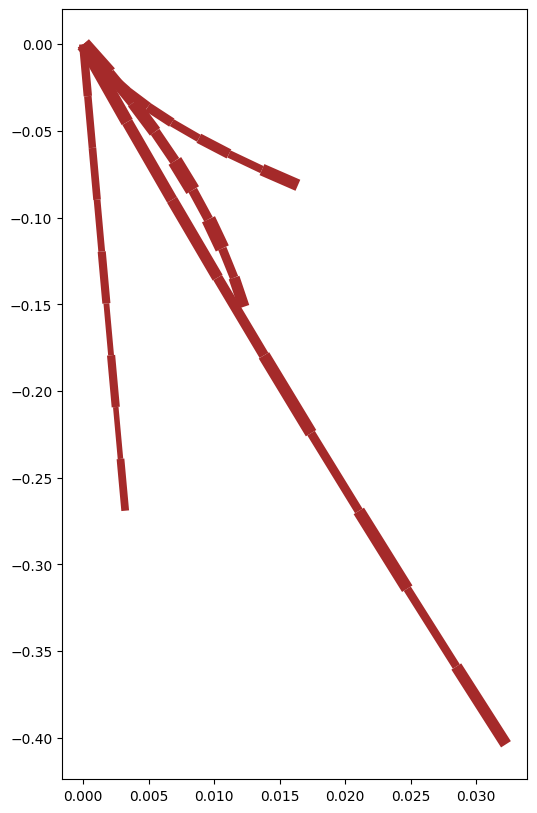

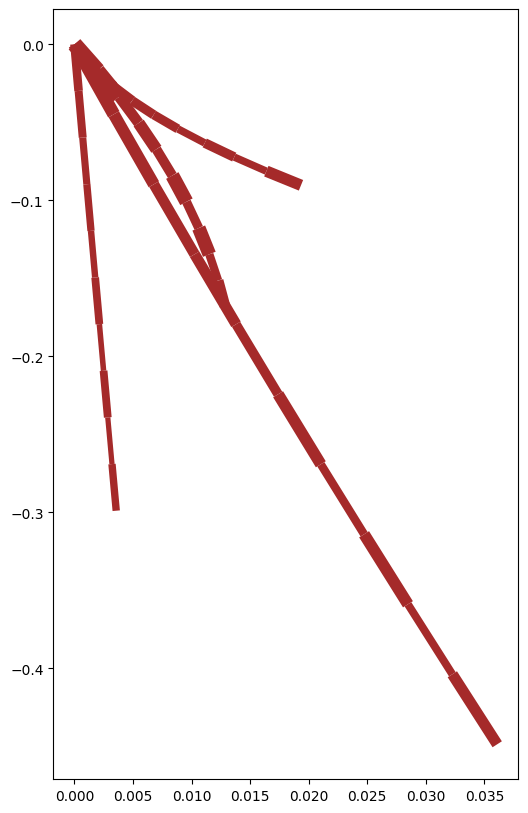

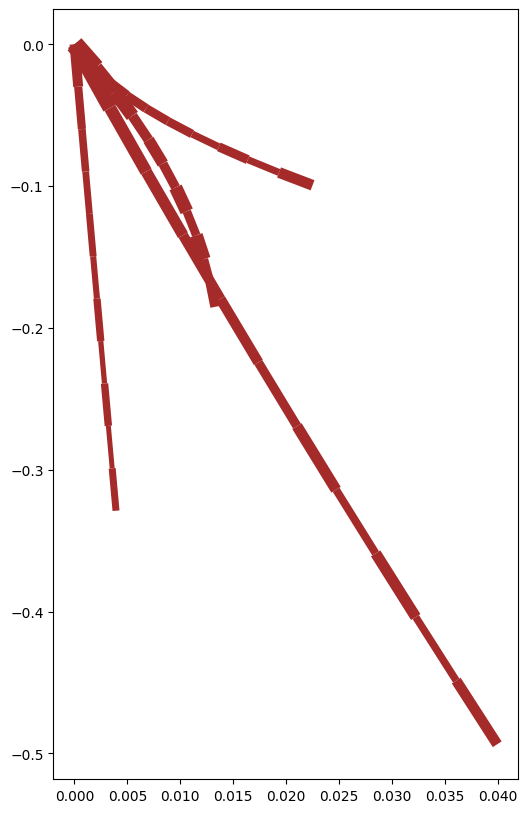

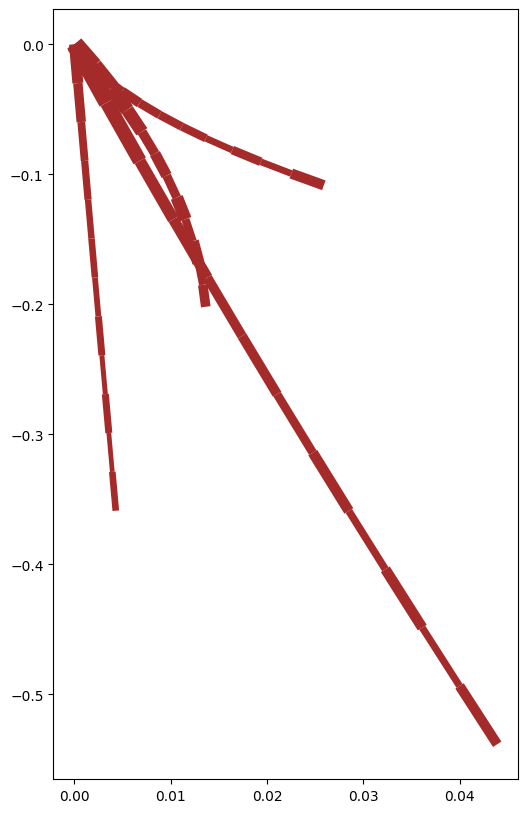

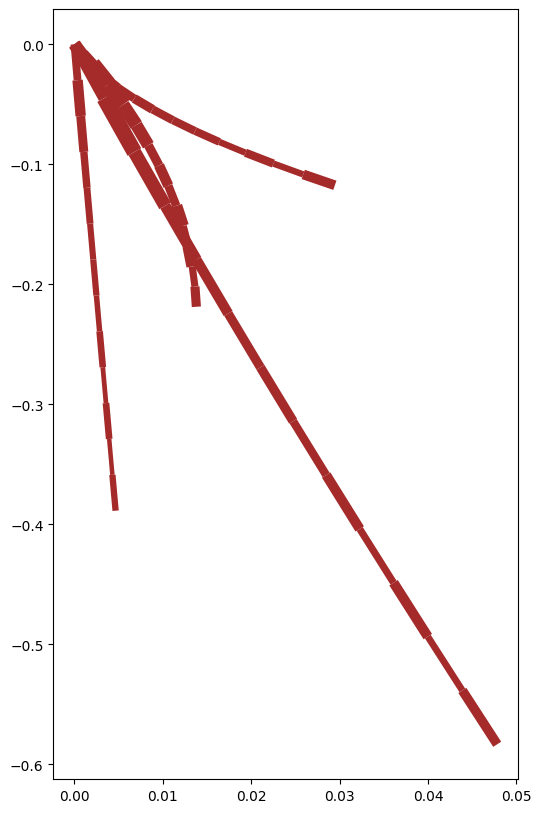

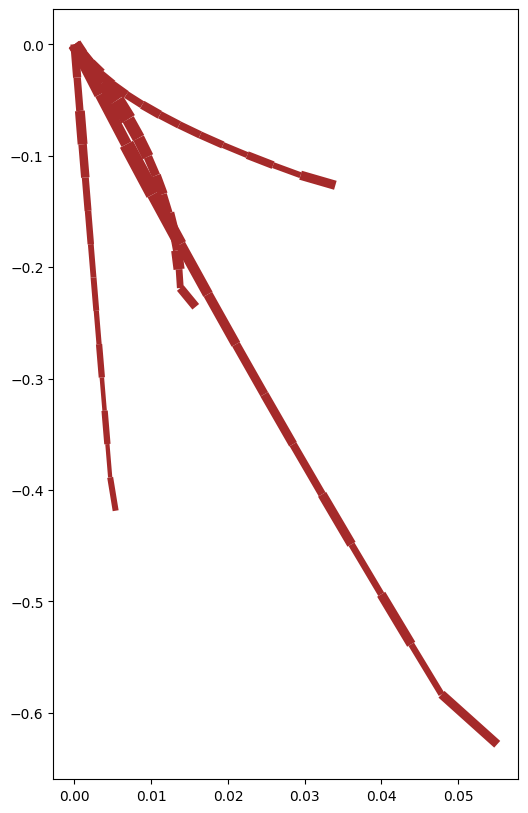

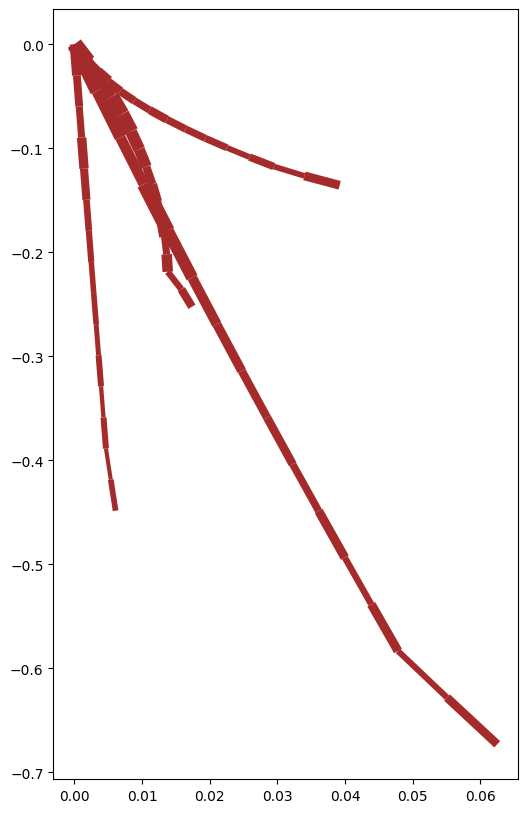

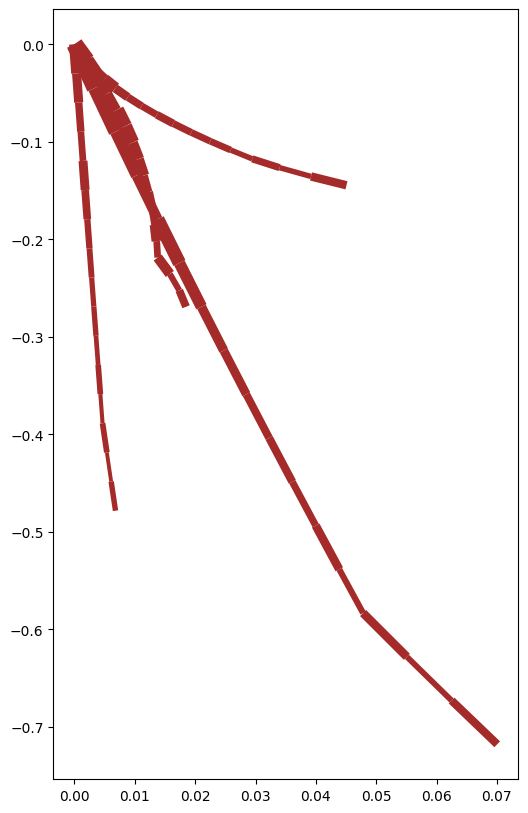

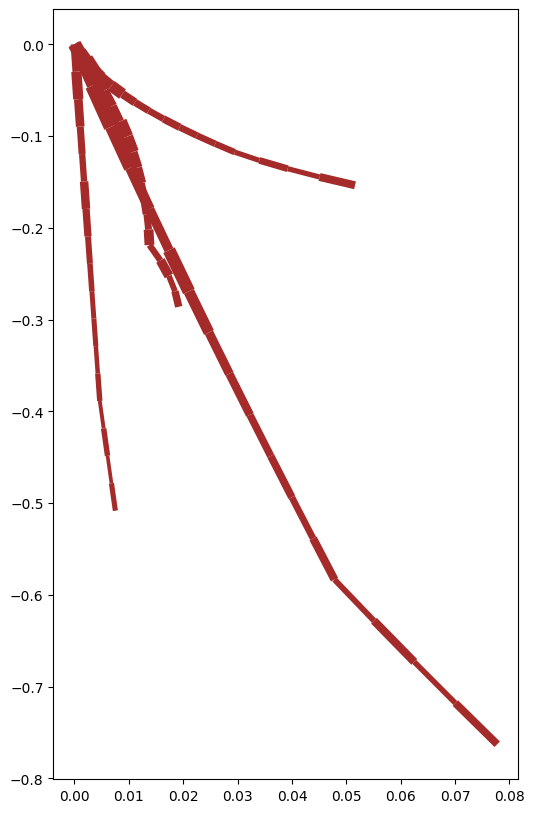

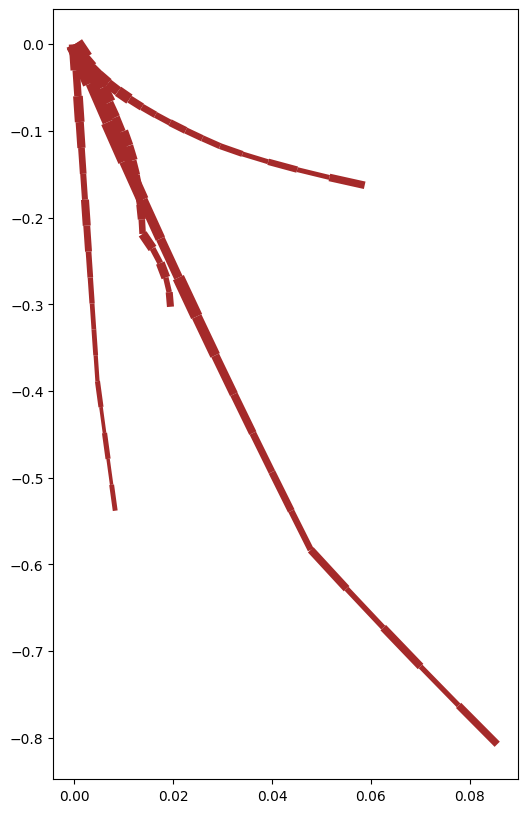

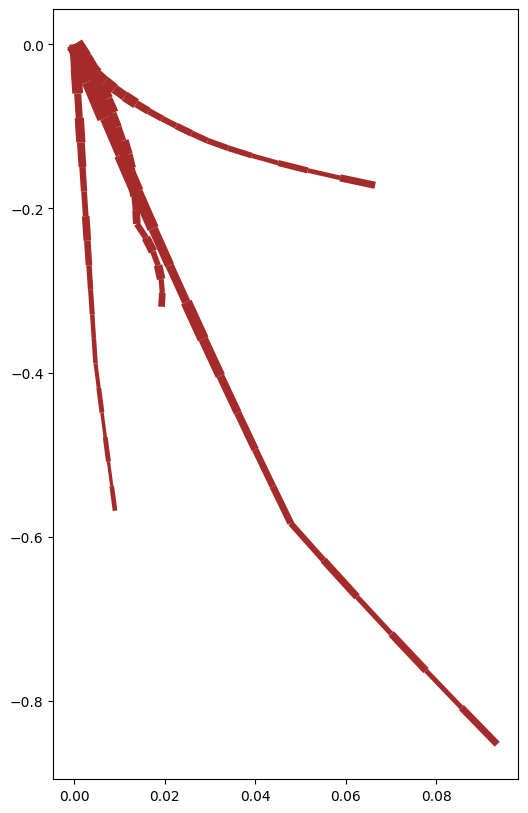

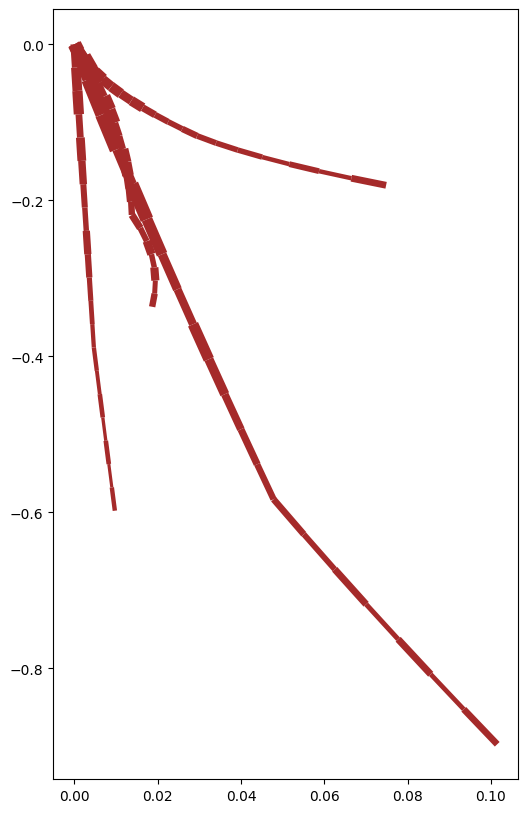

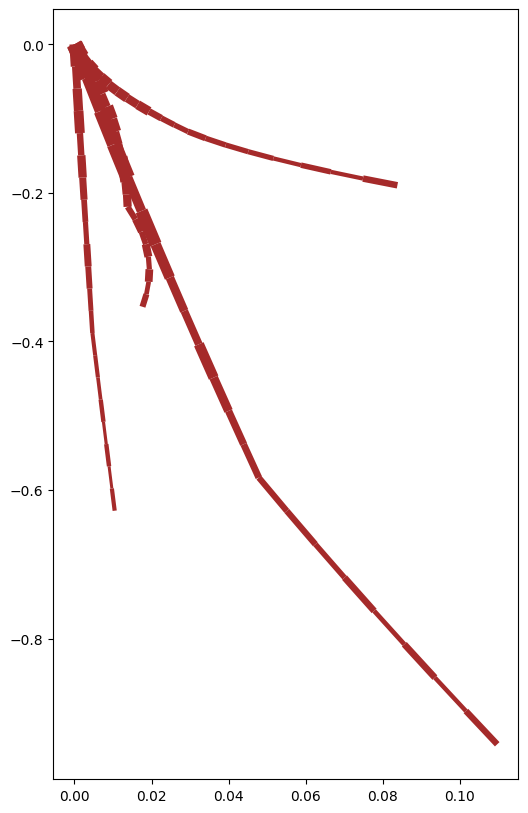

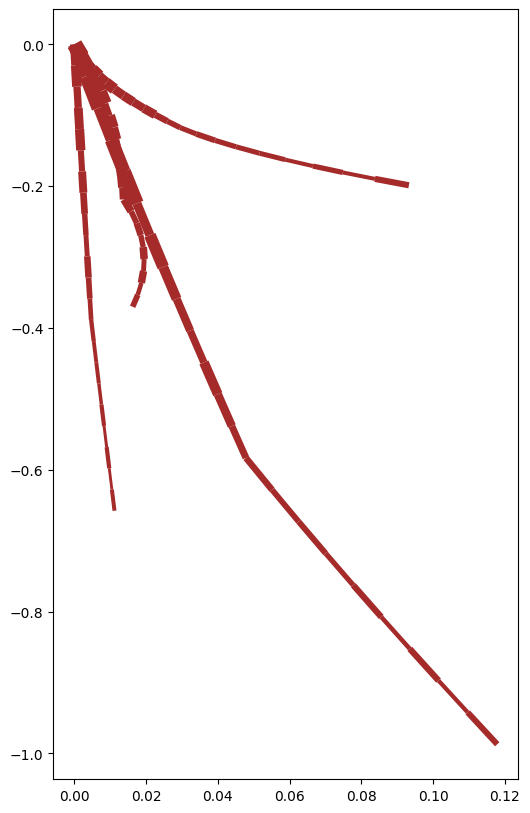

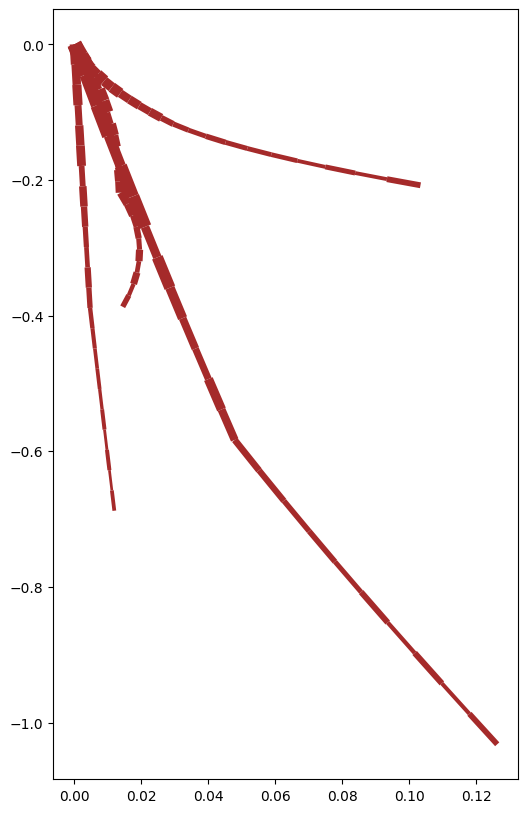

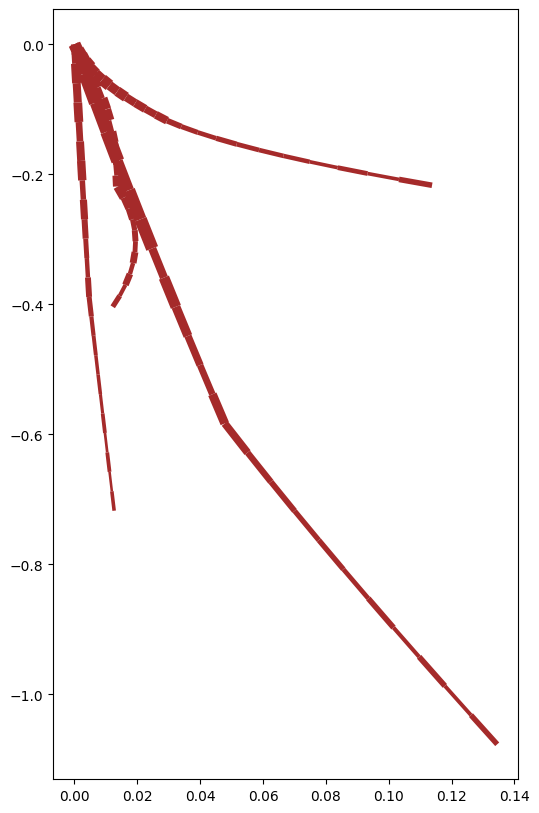

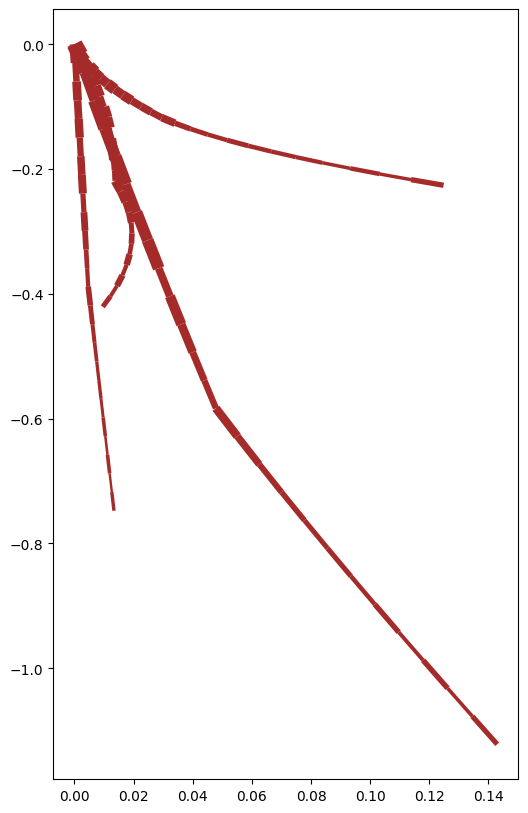

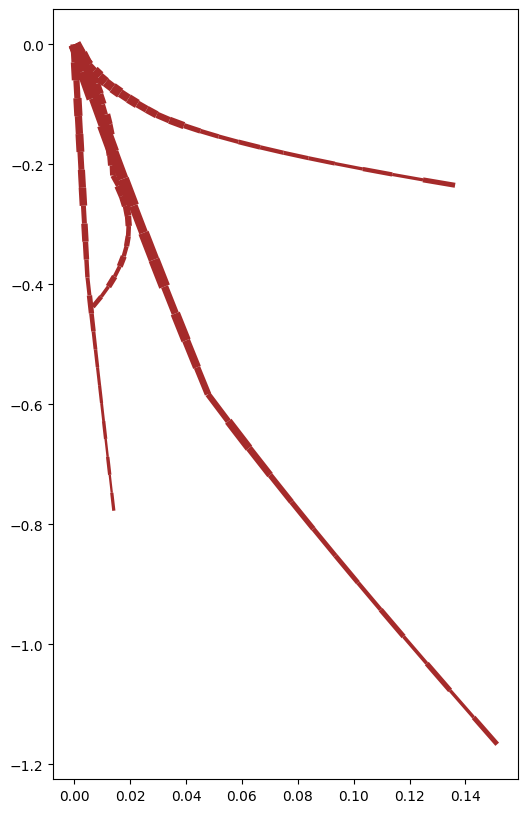

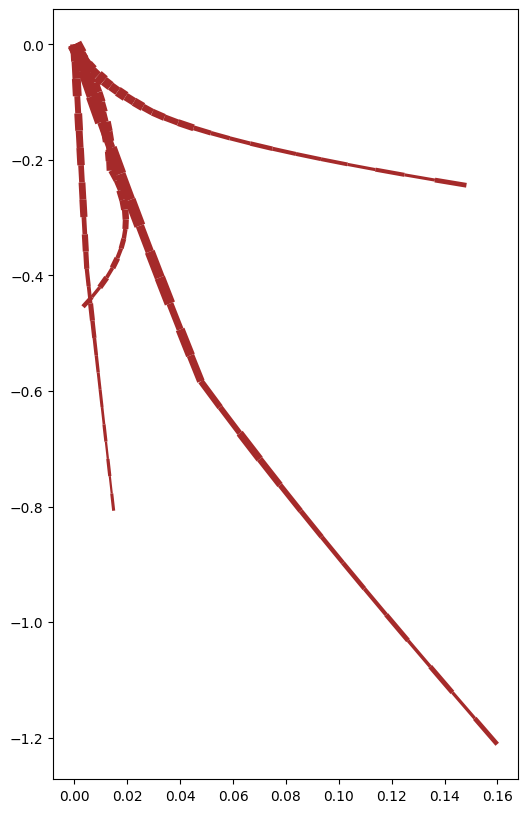

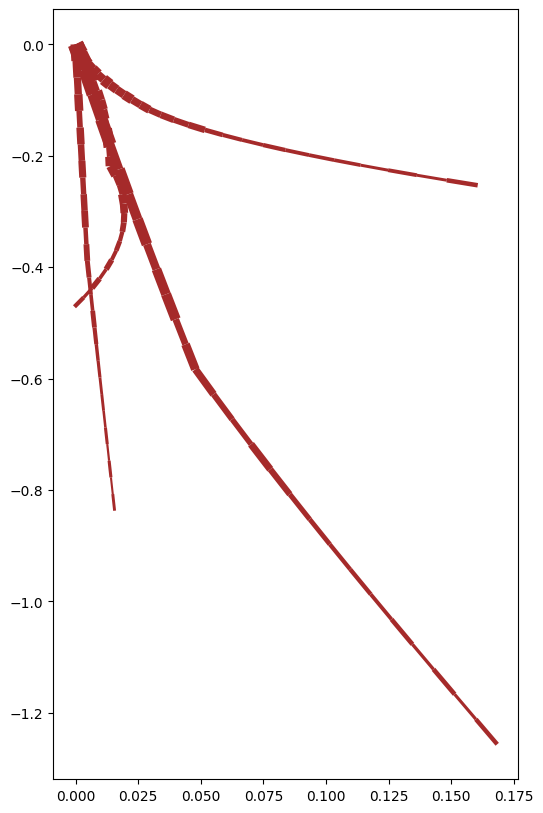

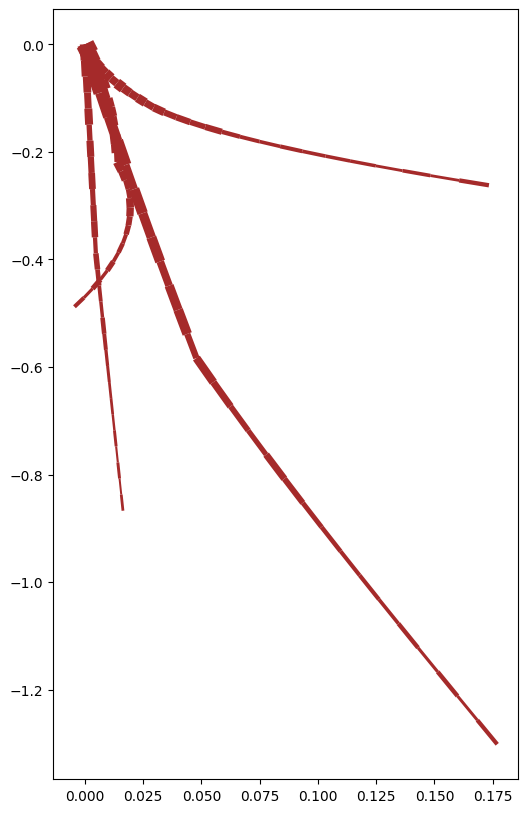

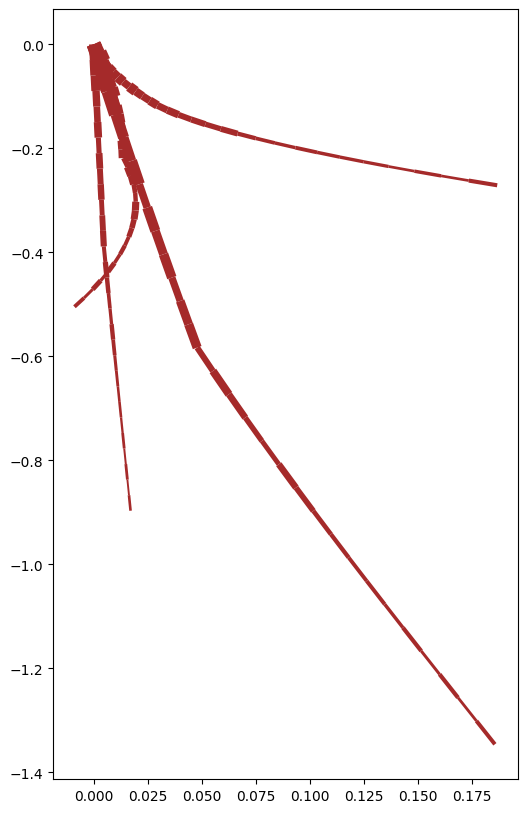

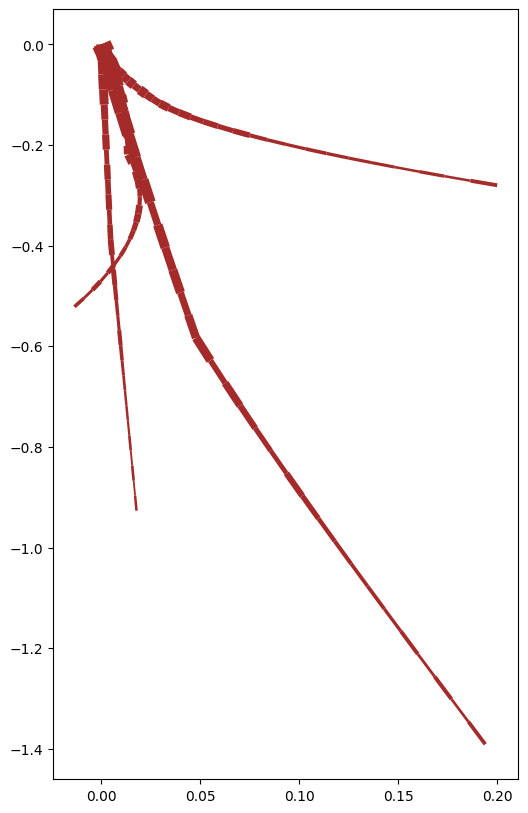

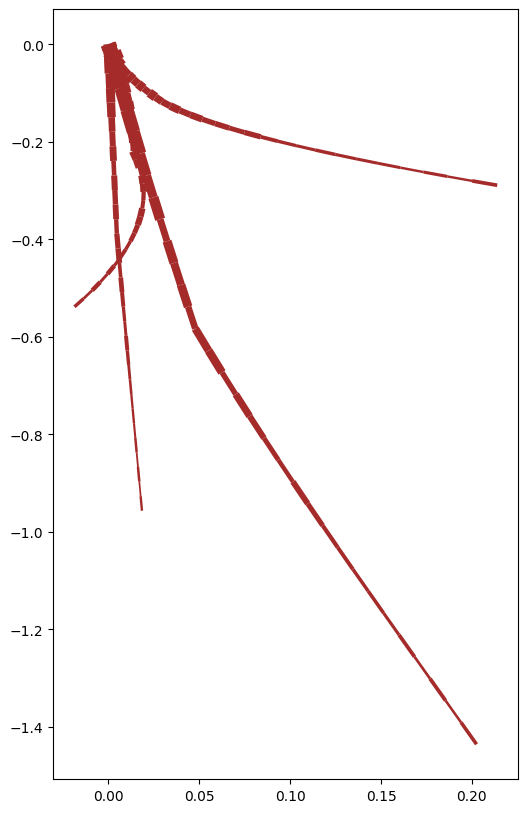

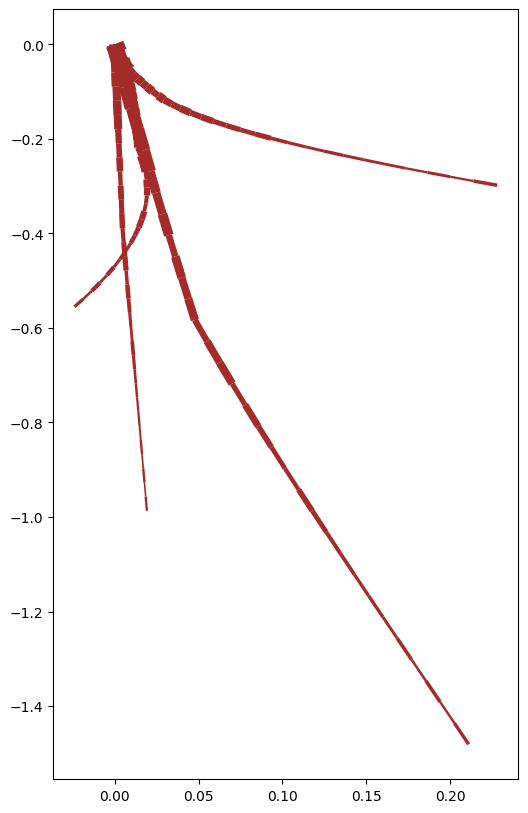

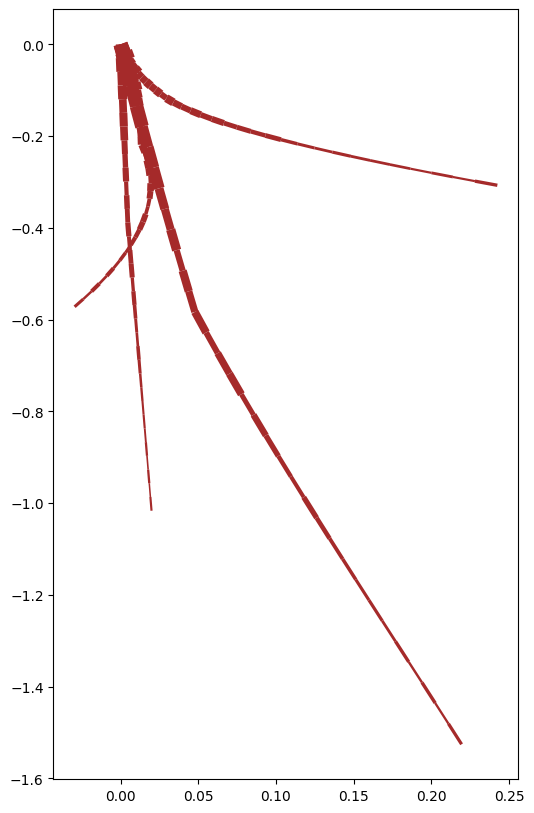

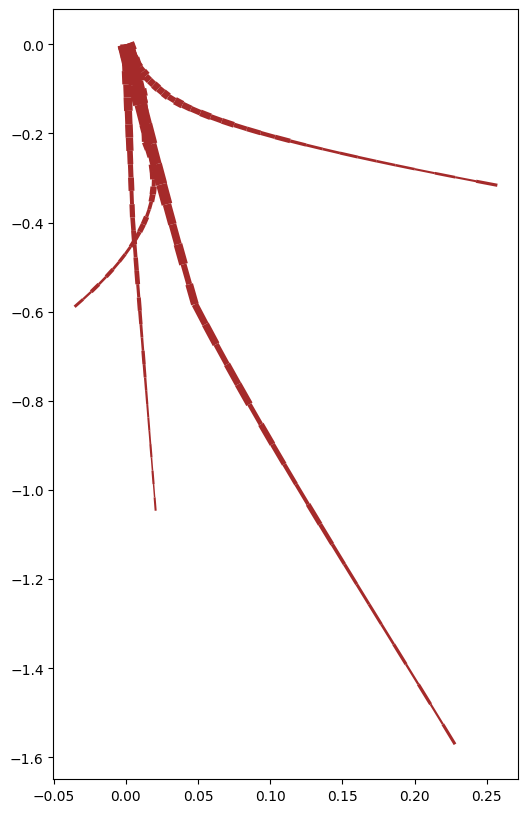

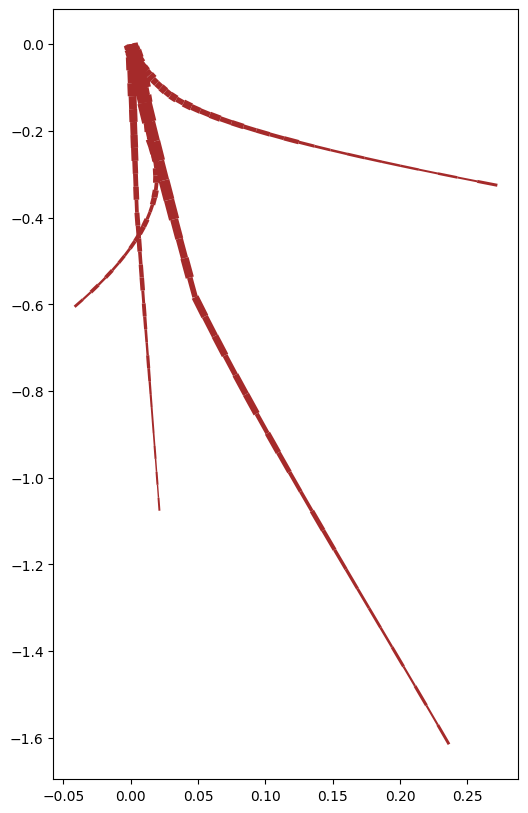

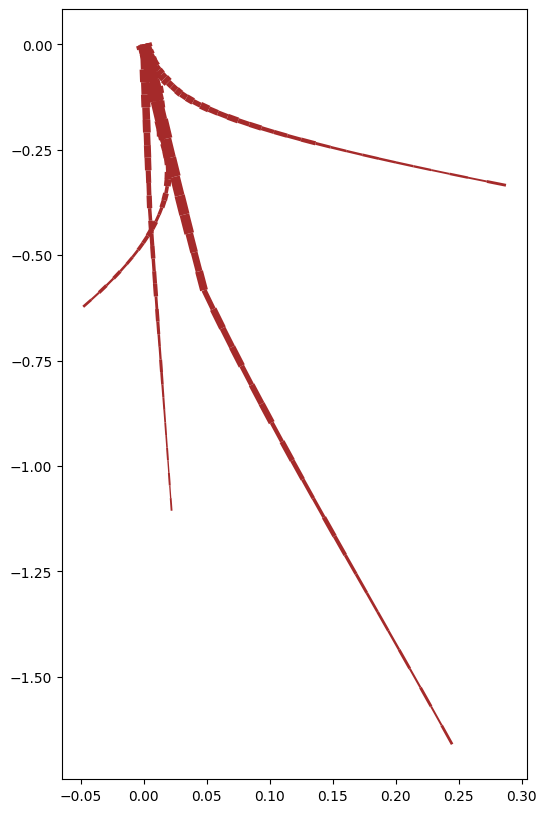

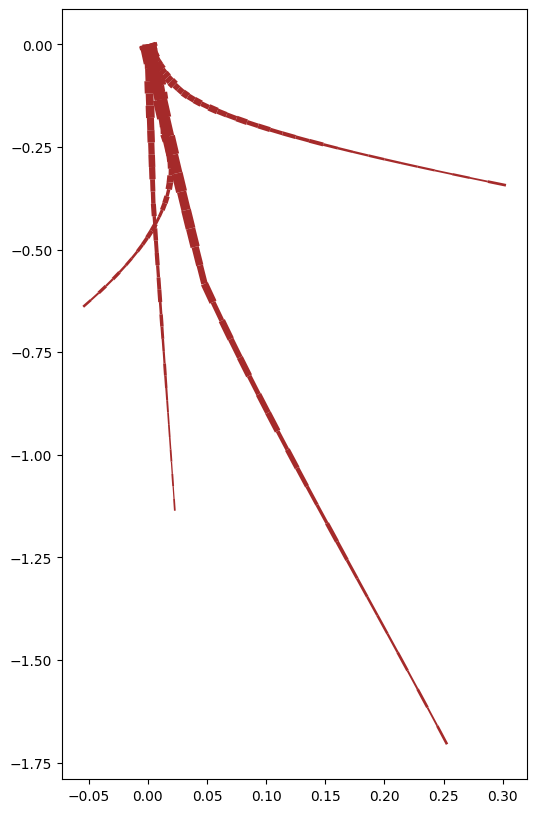

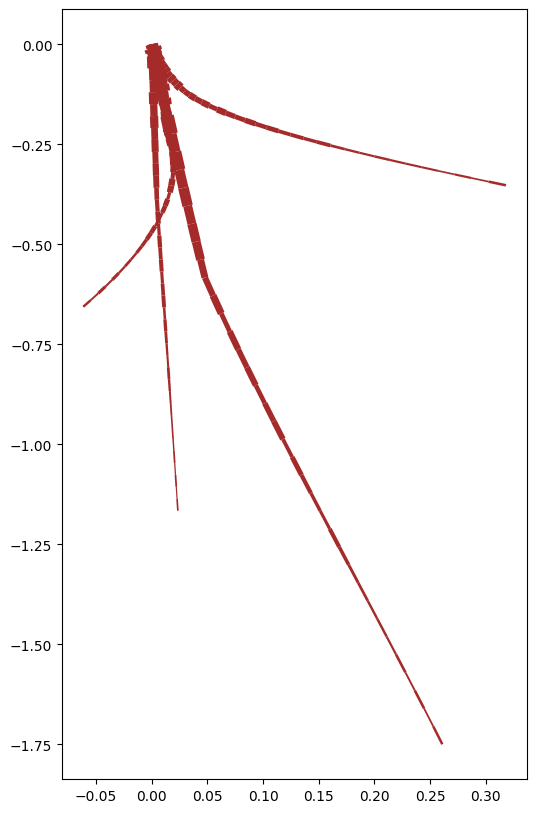

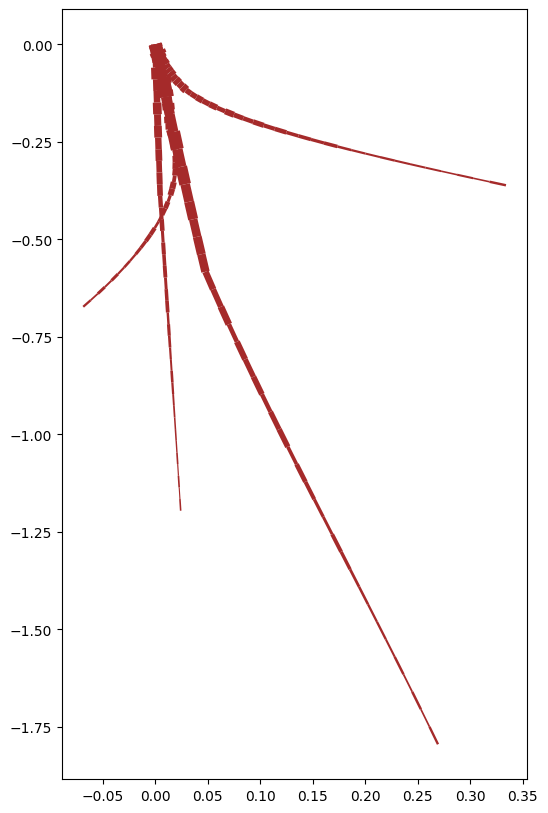

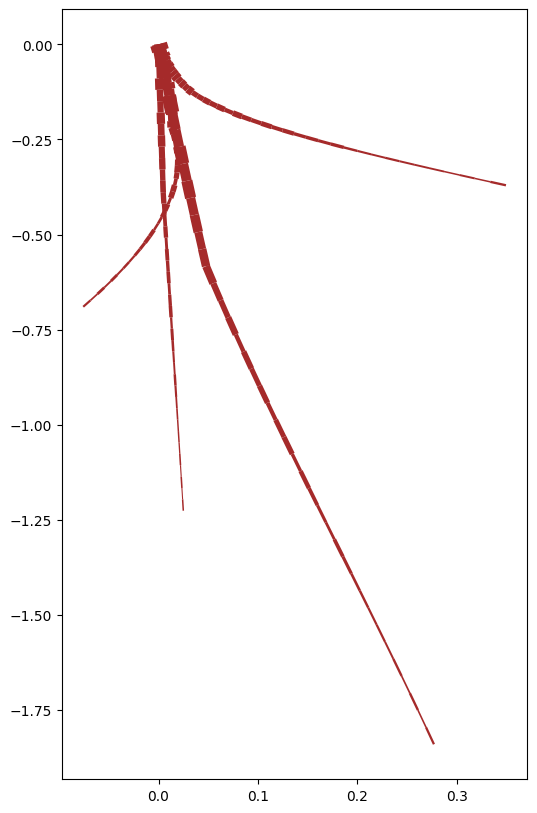

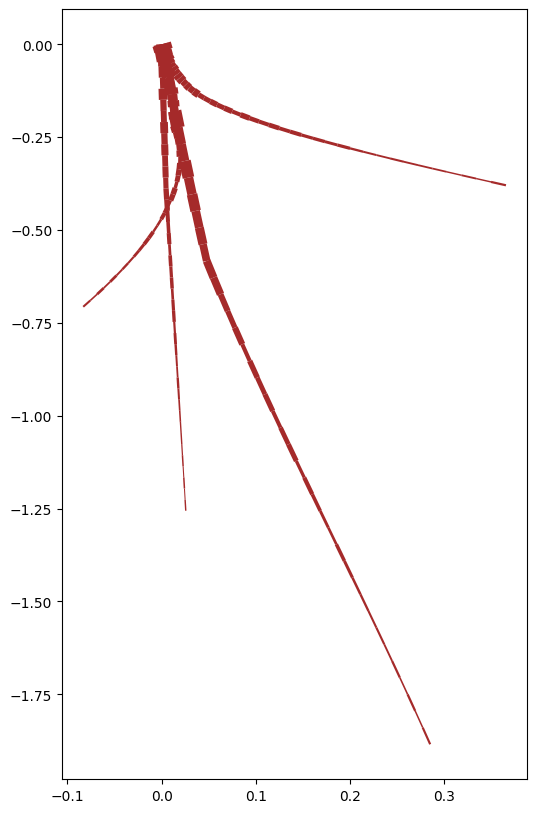

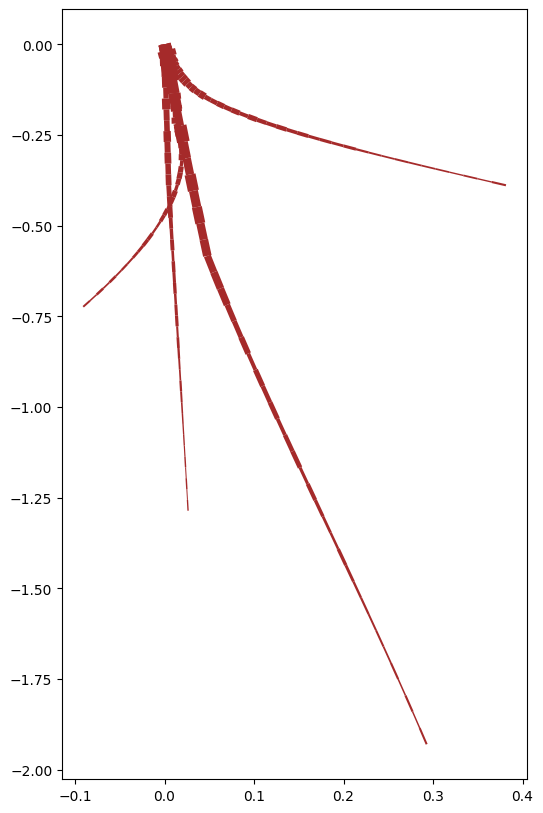

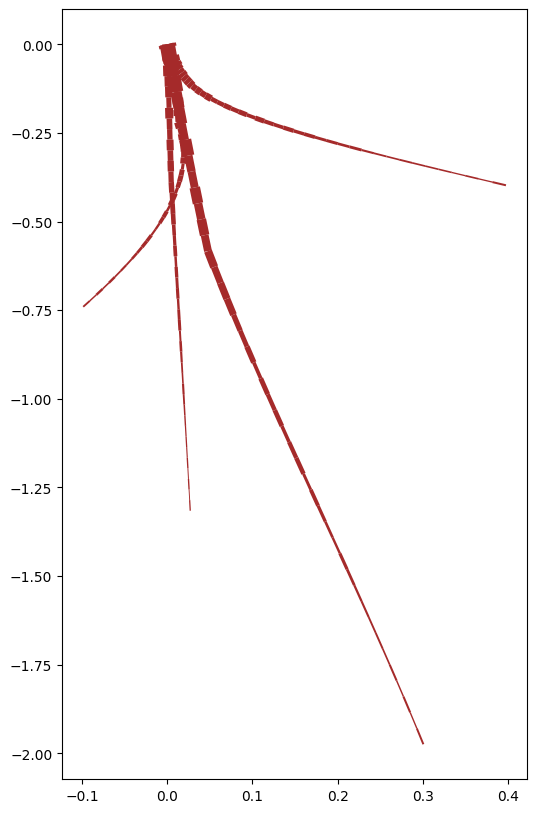

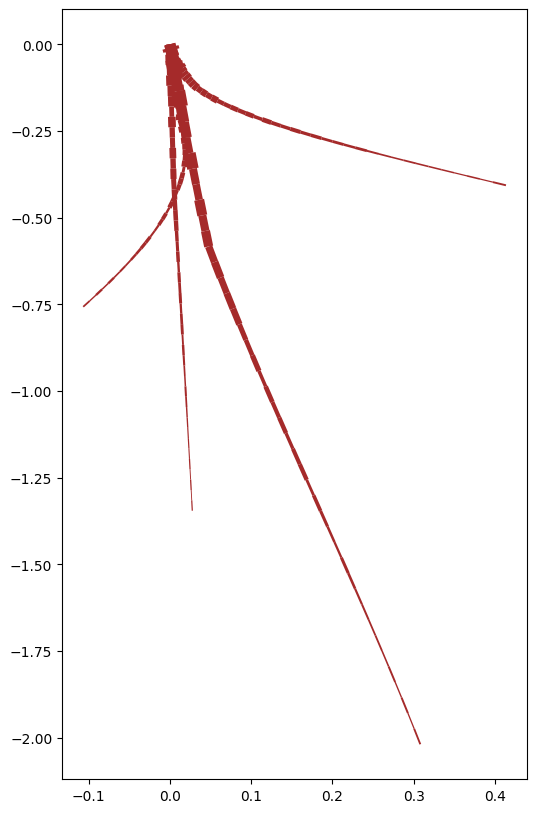

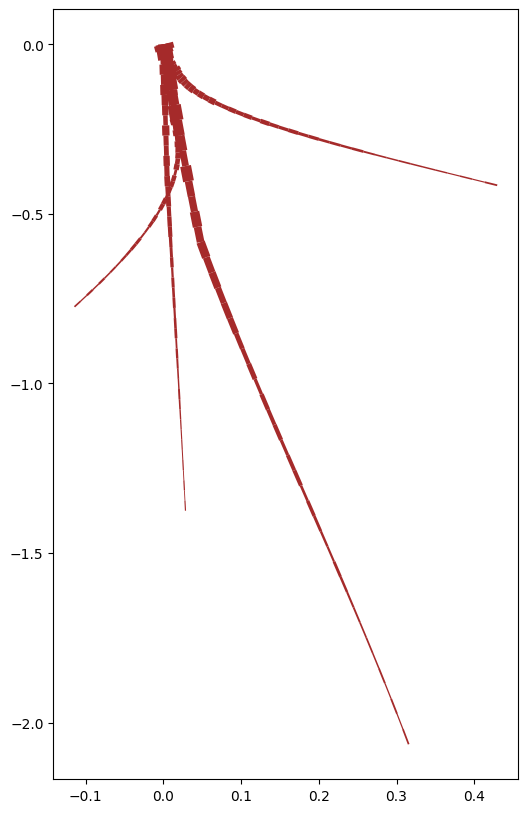

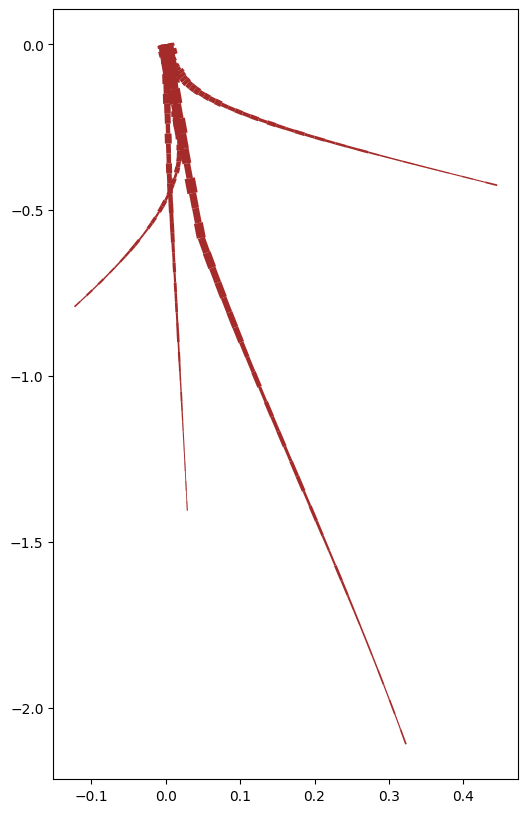

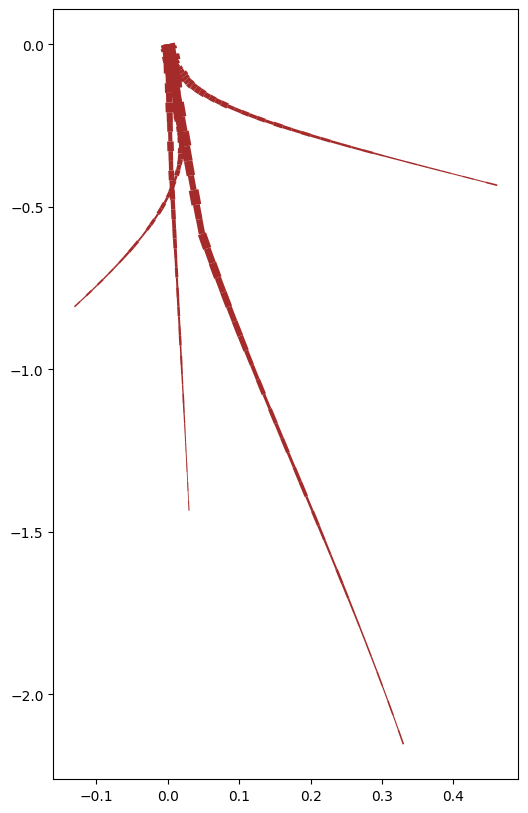

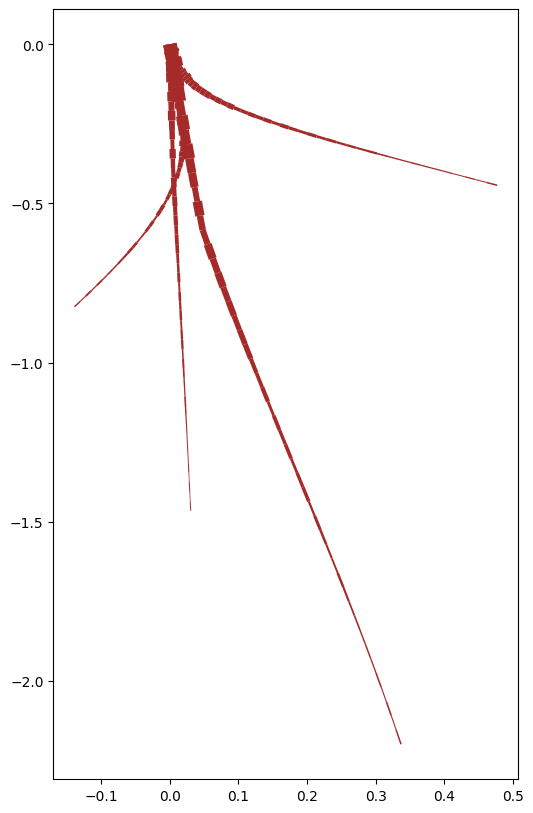

In [22]:
def smooth_array(arr, n=13):
    smoothed_arr = np.copy(arr)
    length = len(arr)
    
    for i in range(length):
        start_idx = max(0, i - n)
        end_idx = min(length, i + n + 1)
        smoothed_arr[i] = np.mean(arr[start_idx:end_idx])
    
    return smoothed_arr


def generate_root(angle, length, start_x=0, start_y=0, width=1.0, num_points=100):
    angle_rad = np.deg2rad(angle)

    t = np.linspace(0, length, num_points)
    phase_shift = np.random.uniform(0, 2 * np.pi)
    sine_wave = np.sin(t * np.pi / length * np.random.uniform(0.5, 2.0) + phase_shift)

    taper = np.linspace(width, 0, num_points)

    x_coords = start_x + taper * np.sin(angle_rad) * sine_wave
    y_coords = start_y - t * np.cos(angle_rad)

    y_coords[0] = start_y
    x_smooth = smooth_array(x_coords)

    x_smooth -= x_smooth[0]

    return x_smooth, y_coords


def generate_multiple_roots(n, start_x=0, start_y=0, length=10, width=1.0, num_points=100):
    angles = np.linspace(-45, 45, n, endpoint=False) + np.random.randint(-5, 5, n)

    roots = []
    for angle in angles:
        length = length + np.random.randint(-7, 7)
        x, y = generate_root(angle, length, start_x, start_y, width, num_points)
        roots.append((x, y))

    return roots


def create_decreasing_width_line(x, y, max_width=10.0, min_width=1e-3):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    num_segments = len(segments)
    widths = np.linspace(max_width, min_width, num_segments)
    lc = LineCollection(segments, linewidths=widths, colors='brown')
    return lc


def create_line_with_width(x, y, widths):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    num_segments = len(segments)
    lc = LineCollection(segments, linewidths=widths, colors='brown')
    return lc


seed = 2717731151
np.random.seed(seed)

SCALING_FACTOR = .95
n_roots = len(df_data.columns) - 1

# Generate and plot multiple roots
roots = generate_multiple_roots(n=n_roots, start_x=0, start_y=0, length=2, width=1.0, num_points=168)
widths = [[] for _ in range(n_roots)]

for i, t in enumerate(df_data.filter(pl.col('DeviceID') == 'OM1').drop(['DeviceID']).iter_rows(), start=1):
    fig, ax = plt.subplots(figsize=(6, 10))
    
    for j, (root, width) in enumerate(zip(roots, t)):
        widths[j].insert(0, 20 * width)
        x = root[0][:i]
        y = root[1][:i]

        lc = create_line_with_width(x, y, widths[j])
        ax.add_collection(lc)
        ax.autoscale()

    for k in range(len(widths)):
        widths[k] = [w * SCALING_FACTOR for w in widths[k]]
        
    
    plt.show()
    
    if i == 50:
        break
    

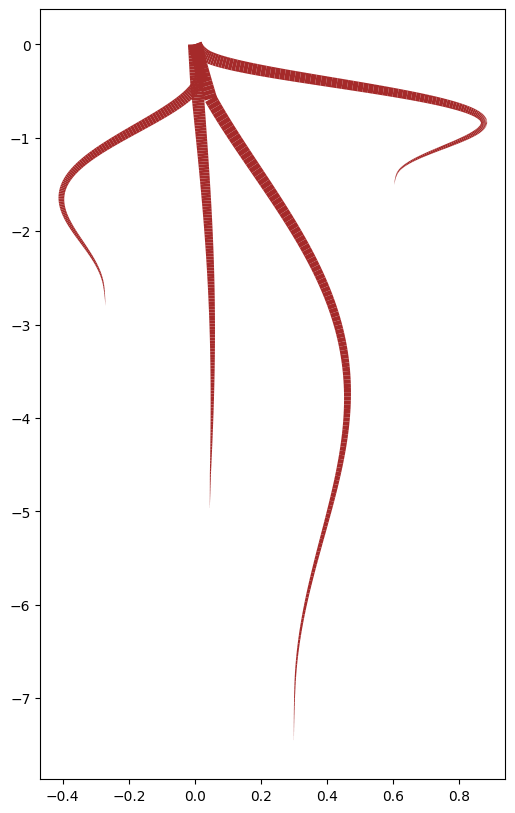

In [302]:
seed = 2717731151
np.random.seed(seed)

roots = generate_multiple_roots(n=n_roots, start_x=0, start_y=0, length=2, width=1.0, num_points=168)

fig, ax = plt.subplots(figsize=(6, 10))

for x, y in roots:
    lc = create_decreasing_width_line(x, y)
    ax.add_collection(lc)
    ax.autoscale()

plt.show()